<a href="https://colab.research.google.com/github/q-vietle/Time-series-and-NPL-project/blob/main/Time_Series_Analysis_in_Pfizer_Vaccine_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#file upload
from google.colab import files
uploaded = files.upload()

Saving vaccination_tweets.csv to vaccination_tweets.csv


the idea are:

Plot the time series data and check for trends, seasonality, and irregularities.

Calculate the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the time series. If the ACF has a sharp drop off after a few lags, but the PACF tails off slowly, the data may be an autoregressive (AR) process. If the PACF has a sharp drop off after a few lags, but the ACF tails off slowly, the data may be a moving average (MA) process. If both the ACF and PACF tail off slowly, the data may be an autoregressive moving average (ARMA) process. If the ACF and PACF have no significant correlation at any lag, the data may be white noise.

Fit different models, including AR, MA, ARMA, and white noise models, to the data and compare their goodness of fit using information criteria such as Akaike information criterion (AIC) and Bayesian information criterion (BIC). The model with the lowest AIC or BIC is usually preferred.

**Text preprocessing**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#data frame
data = pd.read_csv('vaccination_tweets.csv')
#print(data.head(5))

In [ ]:
import re

#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))


#Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))

#Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#print(data.head(5))

**VADER sentiment analysis**

The code block below is about VADER sentiment analysis, which maps lexical feature into emotional intensity; i.e. sentiment score

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize



# Create a SentimentIntensityAnalyzer object
sid = SIA()

# Tokenize the text into individual words and pass them to the polarity_scores() function
data['sentiments'] = data['text'].apply(lambda x: sid.polarity_scores(' '.join(word_tokenize(x))))

# Extract the sentiment scores and add them to separate columns
data['Positive Sentiment'] = data['sentiments'].apply(lambda x: x['pos'] + 1*(10**-6))
data['Neutral Sentiment'] = data['sentiments'].apply(lambda x: x['neu'] + 1*(10**-6))
data['Negative Sentiment'] = data['sentiments'].apply(lambda x: x['neg'] + 1*(10**-6))

# Drop the 'sentiments' column
data.drop(columns=['sentiments'], inplace=True)

# Print the updated DataFrame
#print(data.head(5))


In [ ]:
#fix lookup vader lexicon error and tokeniztion error
import nltk
nltk.download('vader_lexicon')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Now, we finished preprocessing data. We only consider sentiment analysis over time by times series analysis

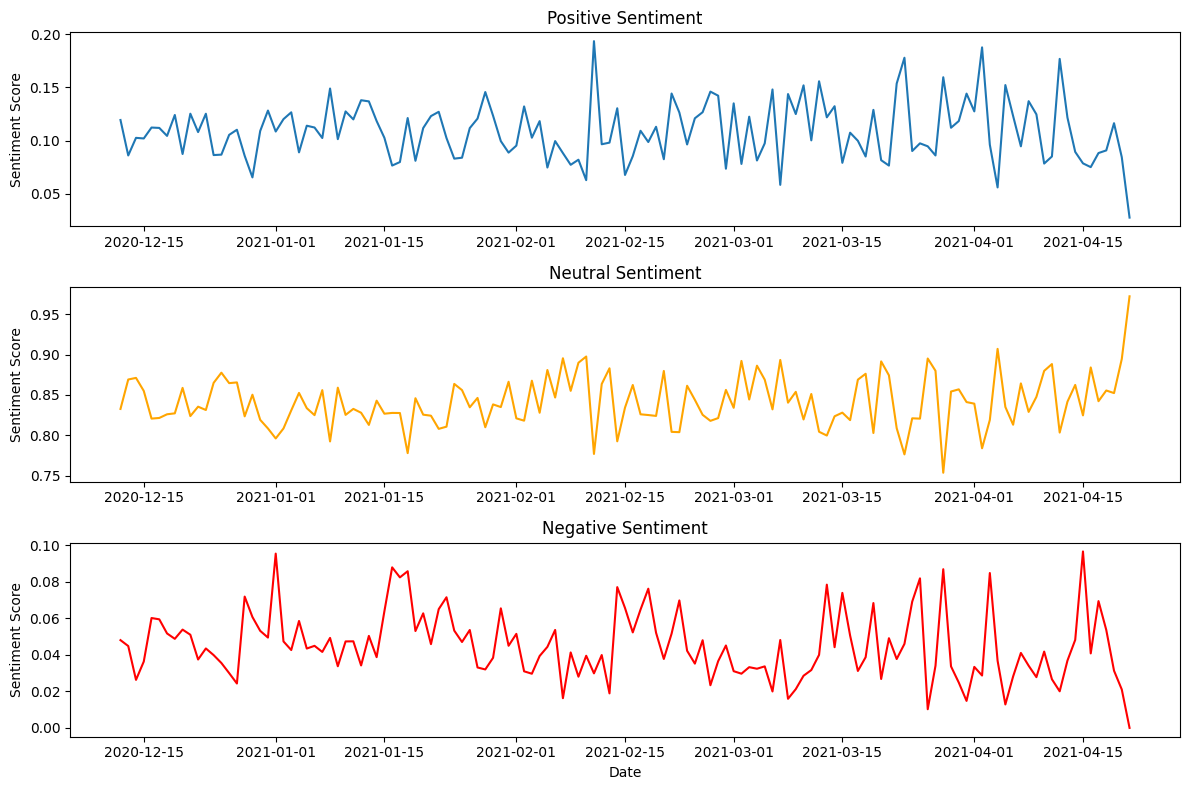

In [ ]:
import matplotlib.pyplot as plt

# Create a dataframe with only categories needed
df = data.loc[:, ['date', 'Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']]

#print(df[:10])

# Convert the 'date' column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'])


# Set the 'date' column as the index
df = df.set_index('date')

# Resample the data to a frequency of 1 day and take the mean of sentiment scores within each interval
df = df.resample('D').mean()

# Set up the figure and axes for the subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))

# Plot Positive Sentiment
ax1.plot(df.index, df['Positive Sentiment'])
ax1.set_title('Positive Sentiment')
ax1.set_ylabel('Sentiment Score')

# Plot Neutral Sentiment
ax2.plot(df.index, df['Neutral Sentiment'], color='orange')
ax2.set_title('Neutral Sentiment')
ax2.set_ylabel('Sentiment Score')

# Plot Negative Sentiment
ax3.plot(df.index, df['Negative Sentiment'], color='red')
ax3.set_title('Negative Sentiment')
ax3.set_ylabel('Sentiment Score')

# Add x-axis label to the last subplot
ax3.set_xlabel('Date')

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


After plotting data, we want to smoothen them to have an insight of trend, seasonality, and so on.

Now, we would like to analyze the residual process with polynomials fit into the raw data

First of all, we analyze the positive sentiment score first

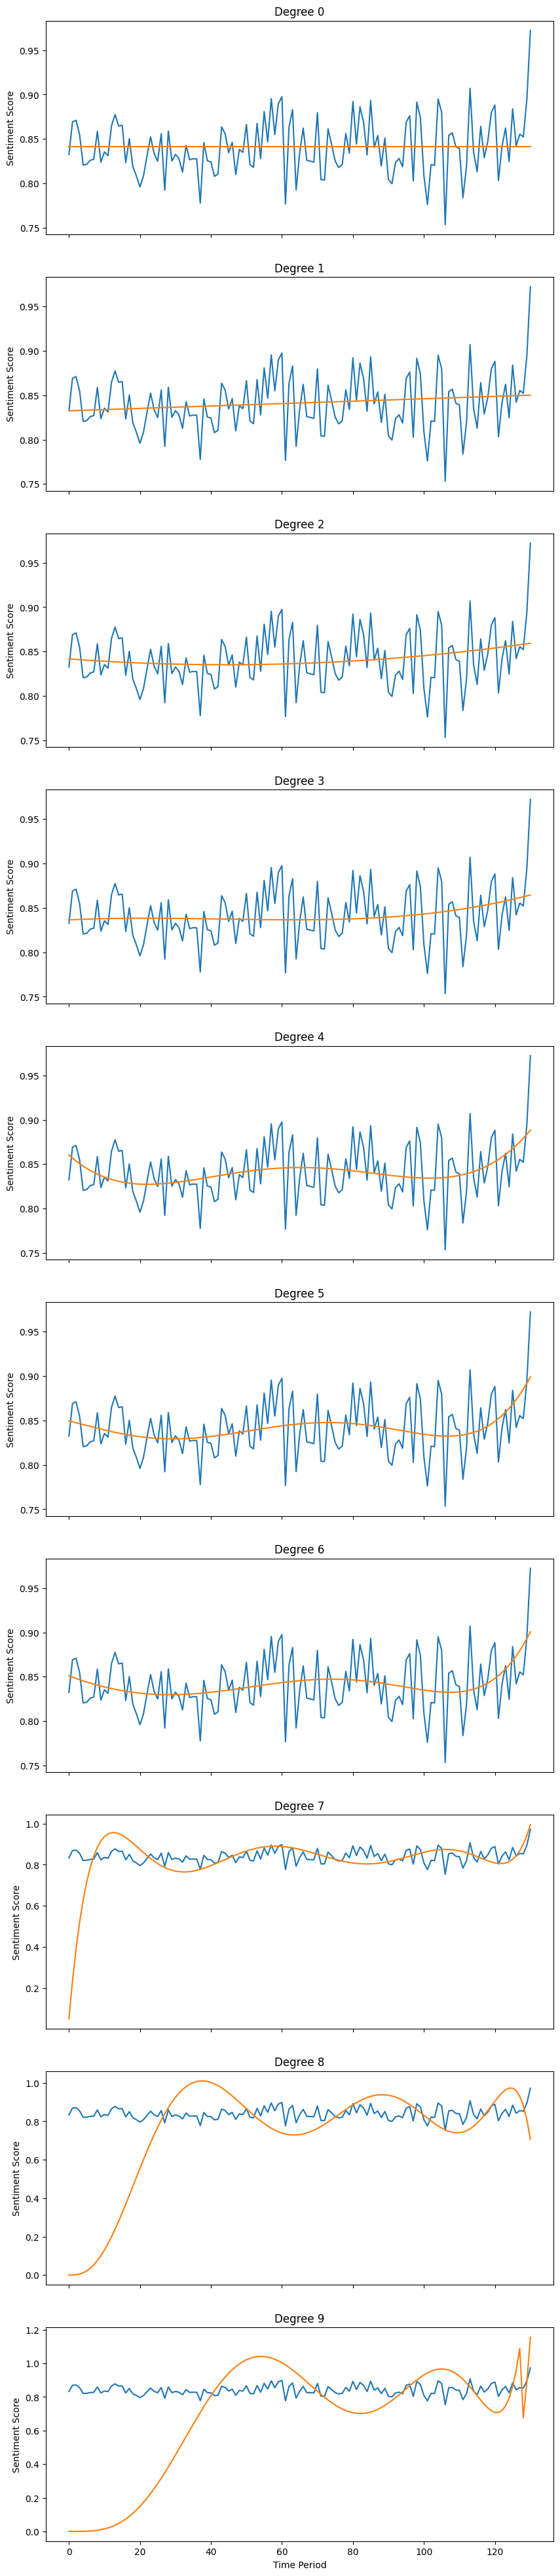

In [ ]:
#remove trend and plot residuals
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

'''Notice: The name of variable is changed to reduce time working, should adjust the name of variables'''

# Load the data
data_frame_of_pos_sentiment = df[['Negative Sentiment']].values
#print(data_frame_of_pos_sentiment[:10].shape)

#time
time = np.arange(data_frame_of_pos_sentiment.shape[0])
data_frame_of_pos_sentiment = data_frame_of_pos_sentiment.reshape(time.shape)

#print(time[:10].shape)


# Fit data into a regression

def poly_fit(time,data_frame,degree):
  designed_matrix = sm.add_constant(np.vander(time, degree+1, increasing= False)[:,:-1])
  model = sm.OLS(data_frame, designed_matrix)
  results = model.fit()
  trend = results.predict(designed_matrix)
  residual = data_frame - trend

  return residual, trend

# Plot
def plot_multiple(x, y_list_1, y_list_2, title_list):
    n = len(y_list_1)
    fig, axes = plt.subplots(nrows=n, ncols=1, sharex=True, sharey=False, figsize=(10, 5*n))
    for i in range(n):
        axes[i].plot(x, y_list_1[i])
        axes[i].plot(x, y_list_2[i])
        axes[i].set_title(title_list[i])
        axes[i].set_ylabel('Sentiment Score')
    axes[n-1].set_xlabel('Time Period')
    plt.show()

x = time
y_list_1 = []
y_list_2 = []
residual_list = []
title_list = []
for i in range(10):
    residual, trend = poly_fit(time, data_frame_of_pos_sentiment, i)
    y_list_1.append(data_frame_of_pos_sentiment)
    y_list_2.append(trend)
    residual_list.append(residual)
    title_list.append("Degree {}".format(i))

plot_multiple(x, y_list_1, y_list_2, title_list)



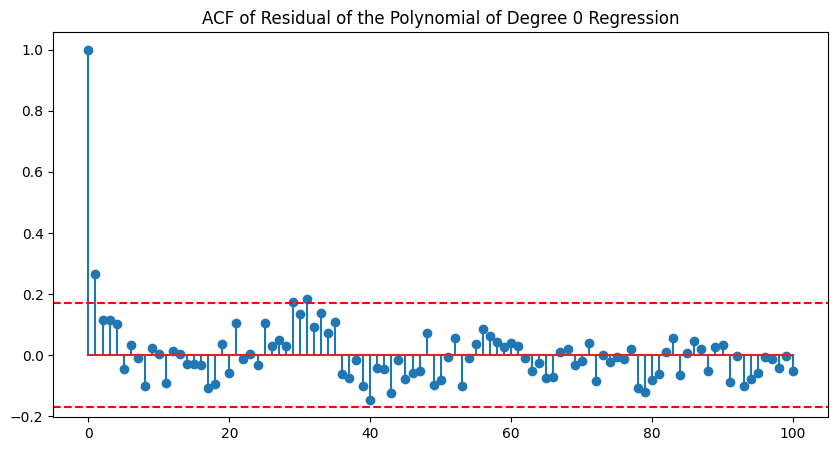

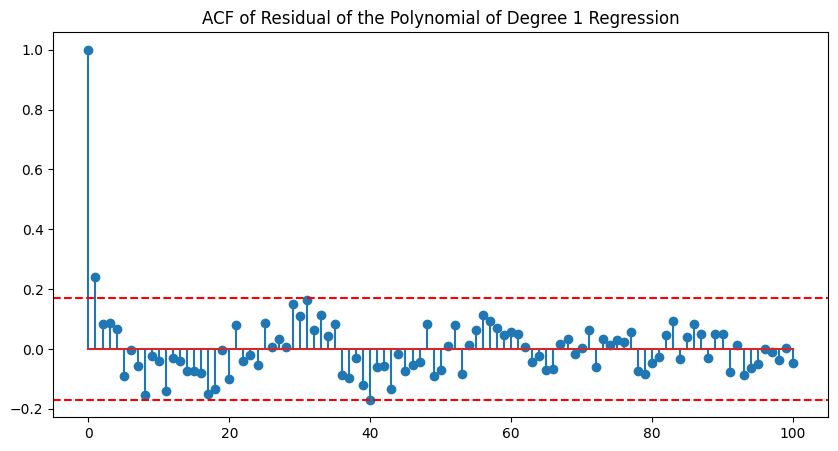

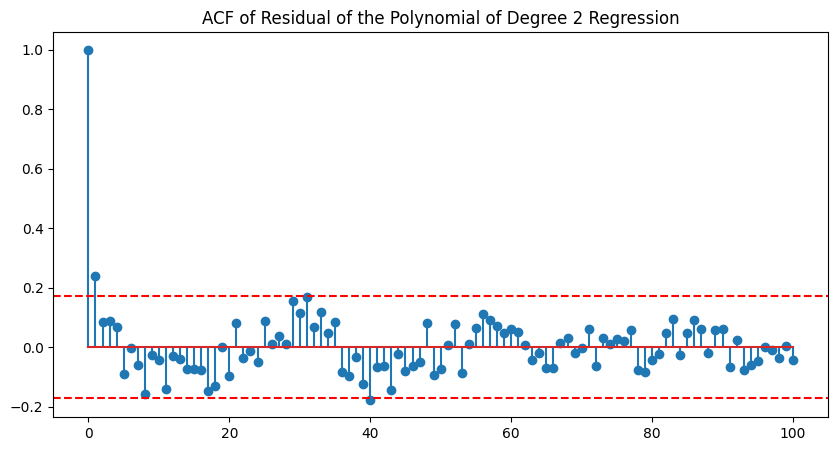

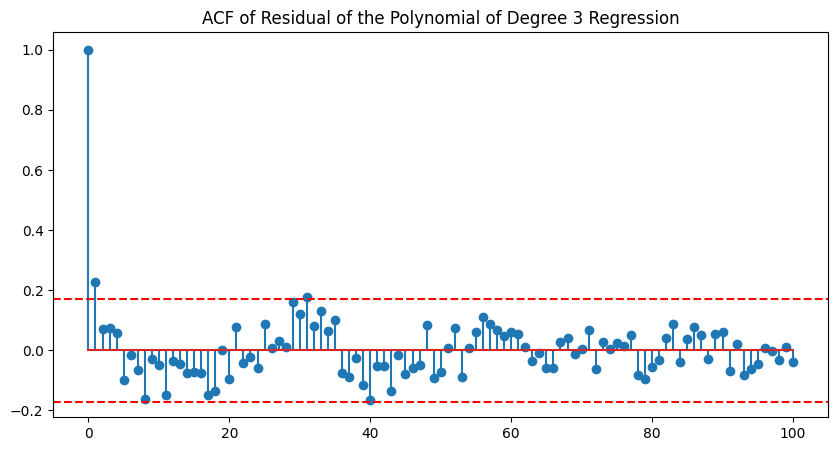

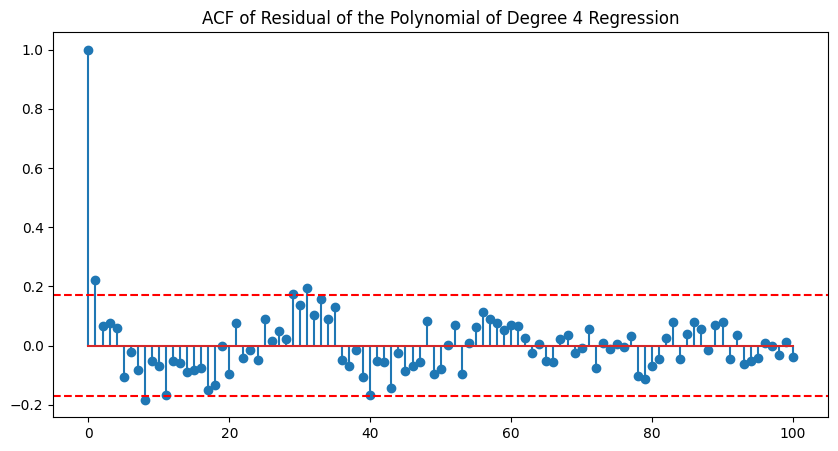

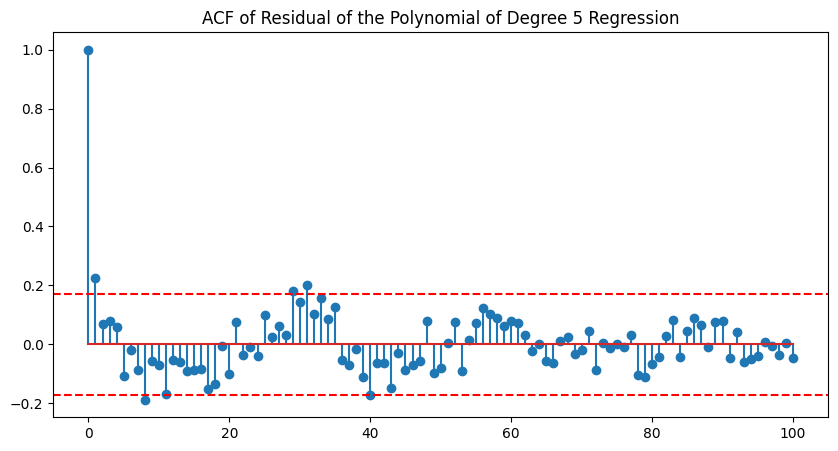

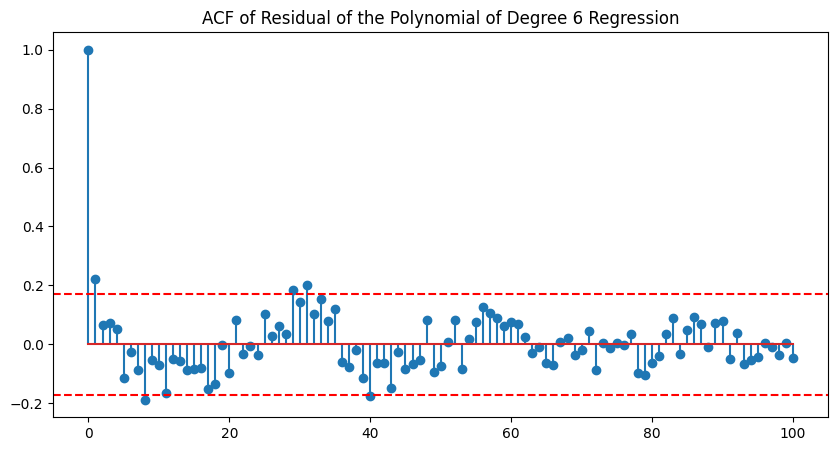

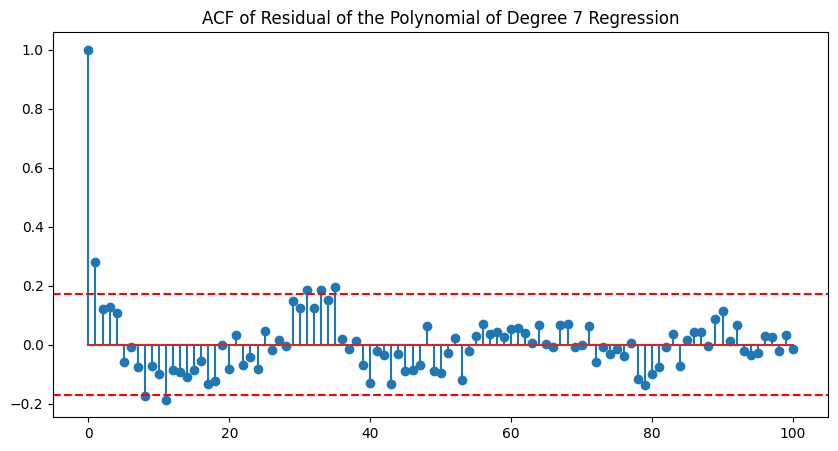

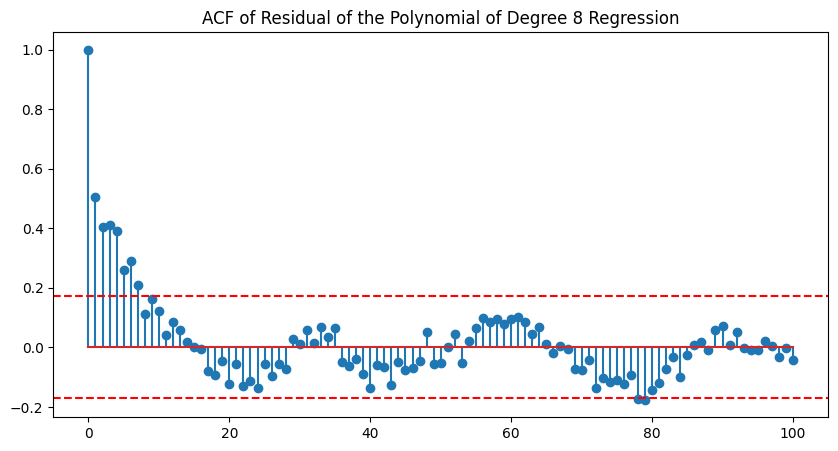

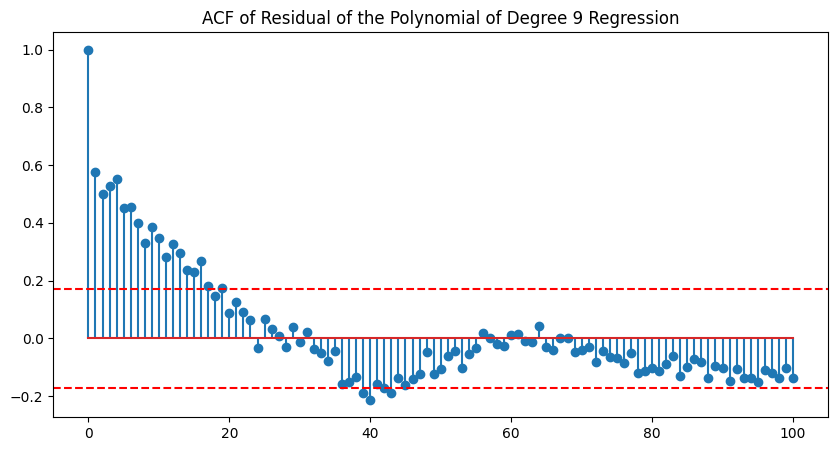

In [ ]:
import scipy.stats as stats

# loop through each set of residuals and plot ACF
for i in range(len(residual_list)):
    residual = residual_list[i]
    acf = sm.tsa.acf(residual, nlags=100)
    sample_size = residual.shape[0]
    alpha = 0.05
    z_crit = stats.norm.ppf(1 - alpha/2)
    k = z_crit/sample_size**(1/2)
    h = np.arange(acf.shape[0])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.stem(h, acf)
    ax.axhline(y=k, color='red', linestyle='--')
    ax.axhline(y=-k, color='red', linestyle='--')
    ax.set_title('ACF of Residual of the Polynomial of Degree {} Regression'.format(i))
    #plt.show()

Above are ACFs of polynomial fits for checking if the plot are white noise. But it is not enough, we need to check for the MA and AR model

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


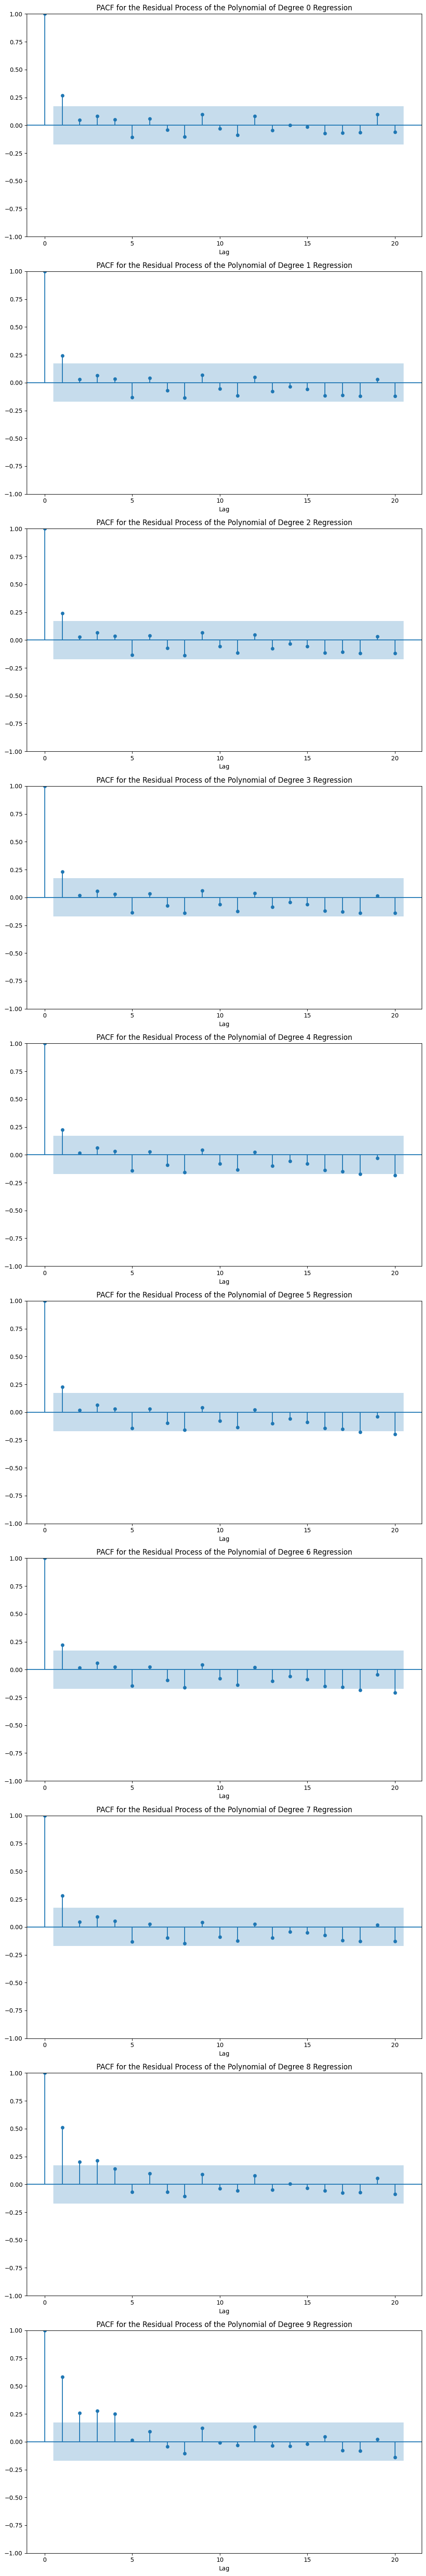

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axs = plt.subplots(nrows=len(residual_list), ncols=1, figsize=(10, 6*len(residual_list)))

# loop over each time series and plot the PACF in a separate subplot
for i, ts in enumerate(residual_list):
    ax = axs[i]
    plot_pacf(ts, ax=ax, lags=20, alpha=0.05)
    ax.set_title(f'PACF for the Residual Process of the Polynomial of Degree {i} Regression')
    ax.set_xlabel('Lag')

plt.tight_layout()
plt.show()


Based on visual analysis as above, we may be able to fit the dataset into ARMA(12,33)

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

# Fit an ARMA model to the data
for i in range(75,80):
  model = sm.tsa.ARIMA(residual_list[7], order=(0, 0, i)).fit()

  print(model.summary())


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:                ARIMA(0, 0, 75)   Log Likelihood                 372.242
Date:                Mon, 24 Apr 2023   AIC                           -590.483
Time:                        19:43:59   BIC                           -369.093
Sample:                             0   HQIC                          -500.523
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.003      0.029      0.977      -0.007       0.007
ma.L1          0.2537      0.632      0.401      0.688      -0.985       1.492
ma.L2         -0.0115      1.289     -0.009      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:                ARIMA(0, 0, 76)   Log Likelihood                 372.520
Date:                Mon, 24 Apr 2023   AIC                           -589.039
Time:                        19:46:47   BIC                           -364.774
Sample:                             0   HQIC                          -497.910
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.058      0.954      -0.007       0.008
ma.L1          0.2713      0.588      0.462      0.644      -0.880       1.423
ma.L2          0.0100      1.059      0.009      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:                ARIMA(0, 0, 77)   Log Likelihood                 372.750
Date:                Mon, 24 Apr 2023   AIC                           -587.500
Time:                        19:49:39   BIC                           -360.360
Sample:                             0   HQIC                          -495.203
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.003      0.054      0.957      -0.006       0.006
ma.L1          0.2888      1.628      0.177      0.859      -2.902       3.480
ma.L2         -0.0158      2.084     -0.008      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:                ARIMA(0, 0, 78)   Log Likelihood                 374.146
Date:                Mon, 24 Apr 2023   AIC                           -588.291
Time:                        19:52:57   BIC                           -358.275
Sample:                             0   HQIC                          -494.826
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.070      0.944      -0.005       0.005
ma.L1          0.2451      1.425      0.172      0.863      -2.547       3.037
ma.L2         -0.0335      1.798     -0.019      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


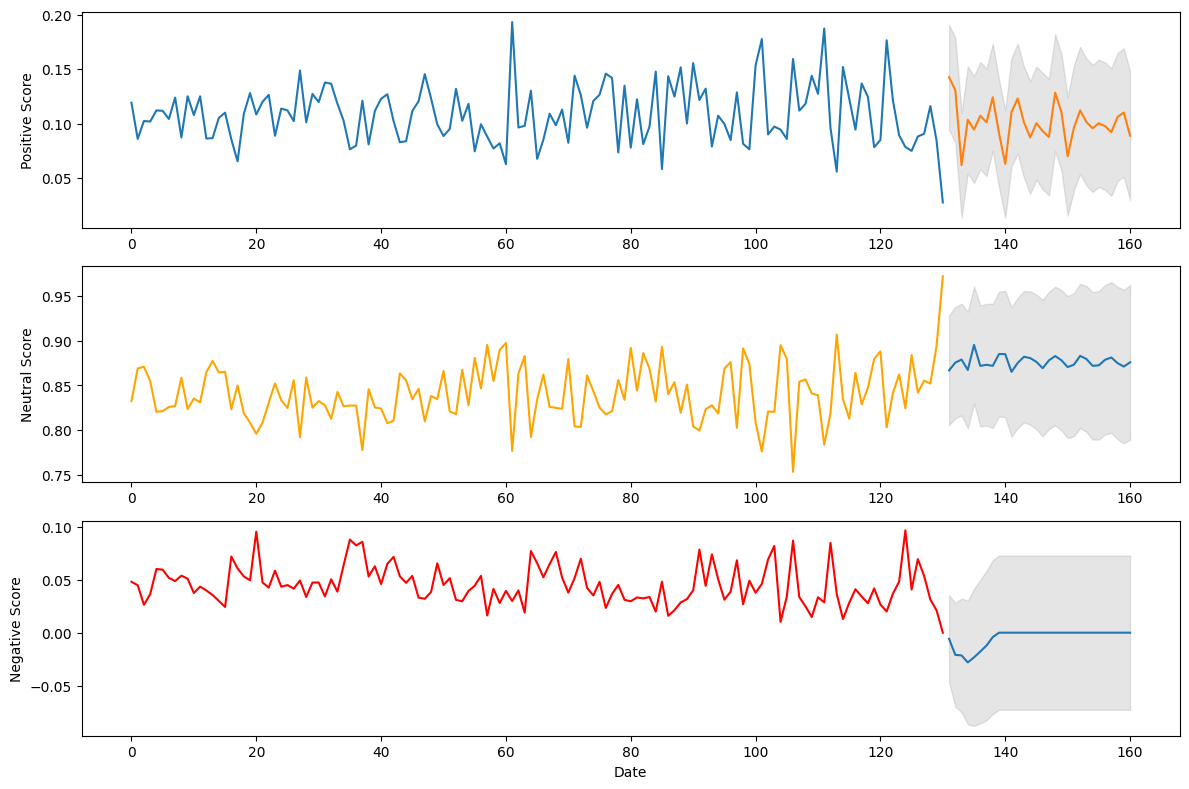

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = data_frame_of_pos_sentiment


# Fit the model
model = SARIMAX(y, order=(0,0,10))
results = model.fit()

# Make predictions for the next days
pred = results.get_prediction(start=131, end=160)

# Get the predicted mean and confidence interval
mean_pred = pred.predicted_mean
ci = pred.conf_int(alpha=0.05)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))

# plot the actual data
ax.plot(time, y, label='Actual')

# plot the predicted values
ax.plot(np.arange(131, 161), mean_pred, color='red', label='Predicted')

# plot the 95% prediction intervals
ax.fill_between(np.arange(131, 161),
                 ci[:, 0],
                 ci[:, 1],
                 color='grey', alpha=0.2, label='Prediction Interval')

# set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Negative Score')
ax.set_title('Semtiment Score in next month ')
ax.legend()

# show the plot
plt.show()
